# Homework 3

CSCI 7000 <br/>
Author: Morgan Byers

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom

## Question 2

In [2]:
def update(t, delta_t, current_val, f_prime):
    return current_val + (delta_t * f_prime)

In [39]:
def s_dot(p, C, D_w, D_s, i):
    return -p @ (D_s @ C @ D_w) @ i

def i_dot(p, C, D_w, D_s, gamma, i):
    return (p @ (D_s @ C @ D_w) @ i) - (gamma * i)

def r_dot(gamma, i):
    return gamma * i

In [40]:
def solve(s_init, i_init, r_init, p, C, omegas, delta_t, max_time, gamma):
    #set up omega matrix
    D_w = np.diag([1 / w for w in omegas])

    #record keeping
    s = [s_init]
    i = [i_init]
    r = [r_init]
    t = [0]

    #solve loop
    idx = 0
    while t[idx] < max_time:
        #update D_s at each timestep
        D_s = np.diag(s[idx].flatten())
        
        #set up derivatives
        s_update = s_dot(p, C, D_w, D_s, i[idx])
        i_update = i_dot(p, C, D_w, D_s, gamma, i[idx])
        r_update = r_dot(gamma, i[idx])

        #update variables
        s.append(update(t[idx], delta_t, s[idx], s_update))
        i.append(update(t[idx], delta_t, i[idx], i_update))
        r.append(update(t[idx], delta_t, r[idx], r_update))

        #update time
        t.append(t[idx] + delta_t)
        idx += 1

    return s, i, r, t

In [62]:
#set up initial conditions
num_groups = 4
gamma = 3
c_bar = 0.5625
w = 1 / 4
delta_t = 0.005
max_time = 4

#same initial conditions apply to each group
percent_susceptible = 0.999
percent_infected = 1 - percent_susceptible
percent_recovered = 0

#create arrays and vectors
C = np.full(shape=(num_groups, num_groups), fill_value=c_bar)
p = np.diag([1, 2, 3, 4])
omegas = np.array([w for i in range(num_groups)])
s_init = np.array([percent_susceptible for i in range(num_groups)]).reshape((4, 1))
i_init = np.array([percent_infected for i in range(num_groups)]).reshape((4, 1))
r_init = np.array([percent_recovered for i in range(num_groups)]).reshape((4, 1))

In [63]:
#solve
s, i, r, t = solve(s_init, i_init, r_init, p, C, omegas, delta_t, max_time, gamma)

#rework results so the final arrays have the four groups as the rows and their values over time as columns
all_s = np.concatenate(s, axis=1)
all_i = np.concatenate(i, axis=1)
all_r = np.concatenate(r, axis=1)

### Part c

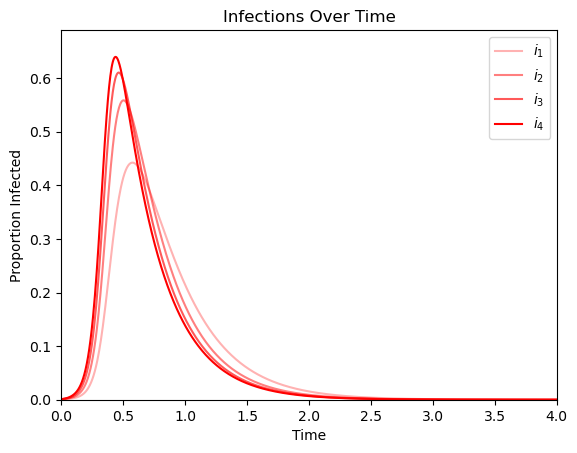

In [83]:
plt.plot(t, all_i[0, :], color='red', alpha=0.3, label=r'$i_1$')
plt.plot(t, all_i[1, :], color='red', alpha=0.5, label=r'$i_2$')
plt.plot(t, all_i[2, :], color='red', alpha=0.65, label=r'$i_3$')
plt.plot(t, all_i[3, :], color='red', alpha=1, label=r'$i_4$')

plt.xlim([0, t[-1]])
plt.ylim([0, np.max(all_i[3,:]) + 0.05])
plt.xlabel('Time')
plt.ylabel('Proportion Infected')

plt.legend(loc='upper right')

plt.title('Infections Over Time')

plt.savefig('question2c.png', dpi=200, bbox_inches='tight')
plt.show()

### Part d

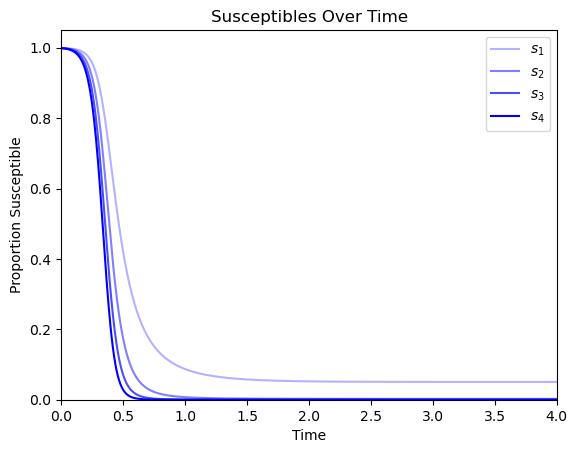

In [87]:
#show s_i(t)
c = 'blue'
plt.plot(t, all_s[0, :], color=c, alpha=0.3, label=r'$s_1$')
plt.plot(t, all_s[1, :], color=c, alpha=0.5, label=r'$s_2$')
plt.plot(t, all_s[2, :], color=c, alpha=0.7, label=r'$s_3$')
plt.plot(t, all_s[3, :], color=c, alpha=1, label=r'$s_4$')

plt.xlim([0, t[-1]])
plt.ylim([0, 1.05])
plt.xlabel('Time')
plt.ylabel('Proportion Susceptible')

plt.legend(loc='upper right')

plt.title('Susceptibles Over Time')

plt.savefig('question2d_susceptibles.png', dpi=200, bbox_inches='tight')
plt.show()

In [92]:
#compute avg relative susceptibility
def compute_avg_susceptibles(p, all_s):
    avg_s = []
    #p is currently a diagonal matrix
    p_vec = np.diag(p)

    for s_vec in all_s.T:
        numerator = np.sum(p_vec * s_vec)
        denominator = np.sum(s_vec)
        avg_s.append(numerator / denominator)
    return avg_s

In [95]:
avg_s = compute_avg_susceptibles(p, all_s)

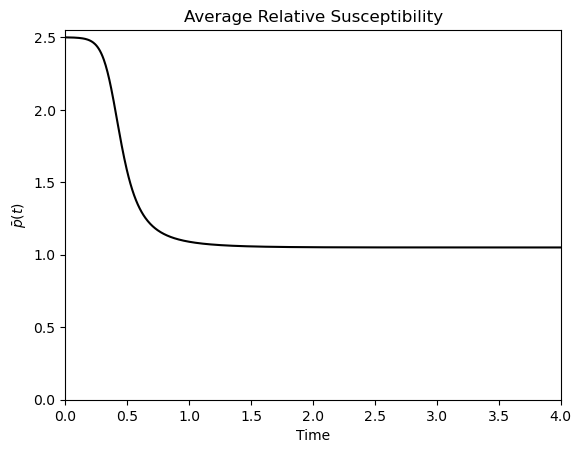

In [101]:
plt.plot(t, avg_s, color='black')

plt.xlim([0, t[-1]])
plt.ylim([0, np.max(avg_s) + 0.05])

plt.xlabel('Time')
plt.ylabel(r'$\bar{p}(t)$')
plt.title('Average Relative Susceptibility')

plt.savefig('question2d_relative.png', dpi=200, bbox_inches='tight')
plt.show()

## Question 3

In [41]:
def draw_nbinom(k, mean, num=10):
    variance = mean + (mean**2) / k
    p = mean / variance
    n = mean ** 2 / (variance - mean)
    
    draw = nbinom.rvs(n=n, p=p)
    draws = nbinom.rvs(n=n, p=p, size=num)

    #we only care about how many children there are total in each new generation
    return np.sum(draws)

In [42]:
def compute_generations(G, k, mean):
    #first generation has one infected
    pop_size = [1]

    pop_size.append(draw_nbinom(k, mean, 1))

    for gen_idx in range(2, G, 1):
        if pop_size[gen_idx - 1] == 0:
            break
        pop_size.append(draw_nbinom(k, mean, pop_size[gen_idx - 1]))

    return pop_size

In [56]:
def run_trials(k, G=10, R0=3, num_trials=100000):
    total_dieout = 0
    for i in range(num_trials):
        pop_size = compute_generations(G, k, R0)
        if len(pop_size) < G or pop_size[-1] == 0:
            total_dieout += 1

    proportion_dies = total_dieout / num_trials
    return proportion_dies

In [57]:
k_vals = [0.1, 0.5, 1, 5, 10]

for k in k_vals:
    q = run_trials(k)
    print(f'k = {k}')
    print(f'\tq = {q:.3f}')
    print('-' * 30)

k = 0.1
	q = 0.837
------------------------------
k = 0.5
	q = 0.499
------------------------------
k = 1
	q = 0.333
------------------------------
k = 5
	q = 0.121
------------------------------
k = 10
	q = 0.091
------------------------------


In [61]:
def run_until_finite(k, G=10, R0=3, num_finite=100000):
    total_dieout = 0
    epidemic_sizes = []

    while total_dieout < num_finite:
        pop_size = compute_generations(G, k, R0)
        if len(pop_size) < G or pop_size[-1] == 0:
            total_dieout += 1
            epidemic_sizes.append(np.sum(pop_size))
    
    return epidemic_sizes

In [62]:
k = 0.1
epidemic_sizes = run_until_finite(k)

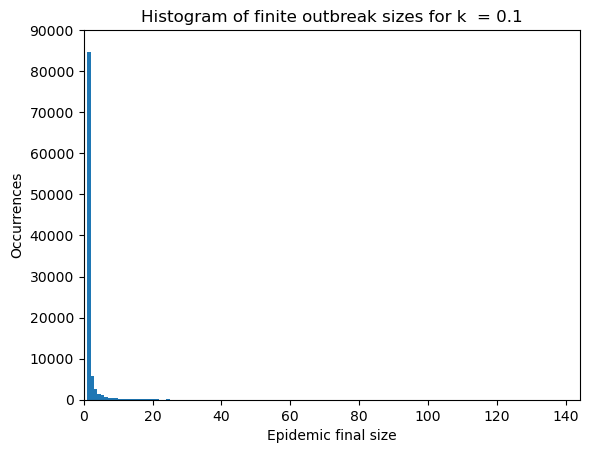

In [71]:
plt.hist(epidemic_sizes, bins=[i for i in range(np.max(epidemic_sizes))])
plt.title(f'Histogram of finite outbreak sizes for k  = {k}')
plt.xlim([0, np.max(epidemic_sizes)])
plt.ylim([0, 90000])
plt.xlabel('Epidemic final size')
plt.ylabel('Occurrences')

plt.savefig(f'q3_k={k}.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
k = 1
epidemic_sizes = run_until_finite(k)

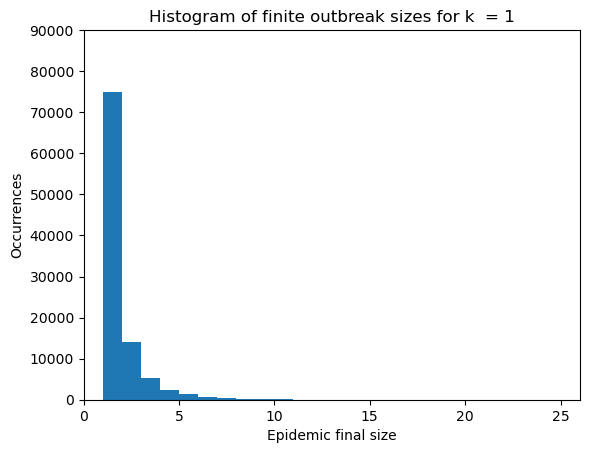

In [73]:
plt.hist(epidemic_sizes, bins=[i for i in range(np.max(epidemic_sizes))])
plt.title(f'Histogram of finite outbreak sizes for k  = {k}')
plt.xlim([0, np.max(epidemic_sizes)])
plt.ylim([0, 90000])
plt.xlabel('Epidemic final size')
plt.ylabel('Occurrences')

plt.savefig(f'q3_k={k}.png', dpi=200, bbox_inches='tight')
plt.show()

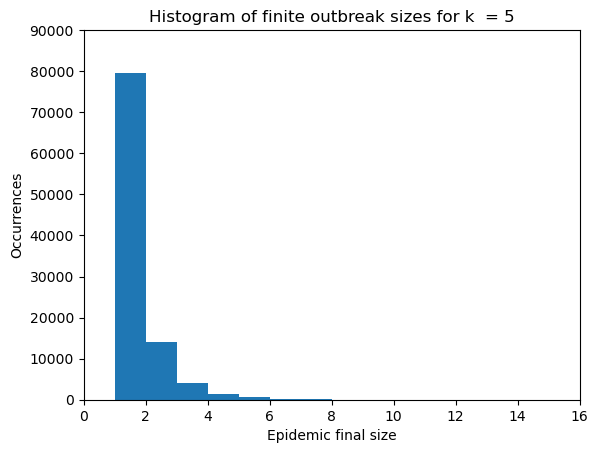

In [74]:
k = 5
epidemic_sizes = run_until_finite(k)
plt.hist(epidemic_sizes, bins=[i for i in range(np.max(epidemic_sizes))])
plt.title(f'Histogram of finite outbreak sizes for k  = {k}')
plt.xlim([0, np.max(epidemic_sizes)])
plt.ylim([0, 90000])
plt.xlabel('Epidemic final size')
plt.ylabel('Occurrences')

plt.savefig(f'q3_k={k}.png', dpi=200, bbox_inches='tight')
plt.show()